In [1]:
import os
#os.environ['JAX_PLATFORM_NAME'] = 'cpu'
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from abm.spatial_compartmental.utils import calc_start_n_initial,Neighbourhood
from abm.spatial_compartmental.sir import get_abm
from functools import partial
from flax import nnx
from checkpointing import CheckPointer
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
abm = get_abm(Neighbourhood.VONNEUMANN, vmap=True)

In [3]:
def vectorized_abm_state_counts_jax(abm_grids_batch):
    """
    Calculates state counts for a batch of ABM grids using JAX.
    
    Args:
        abm_grids_batch (jnp.ndarray): An array of shape (batch_size, 3, 5, 5)
                                       representing all grids at a single time step.
                                      
    Returns:
        dict: A dictionary where keys are state names (str) and values are
              JAX arrays (shape (batch_size,)) containing the counts of that
              state for each grid in the batch.
    """
    counts = {}
    # Unoccupied: (layer0==0) & (layer1==0) & (layer2==0)
    counts["Unoccupied"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2) # Sum over the 5x5 grid dimensions
    ).astype(jnp.int32) # Ensure integer counts
    
    # Susceptible: (layer0==0) & (layer1==1) & (layer2==0)
    counts["Susceptible"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 1) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2)
    ).astype(jnp.int32)
    
    # Infected: (layer0==1) & (layer1==0) & (layer2==0)
    counts["Infected"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 1) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2)
    ).astype(jnp.int32)
    
    # Recovered: (layer0==0) & (layer1==0) & (layer2==1)
    counts["Recovered"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 1),
        axis=(1, 2)
    ).astype(jnp.int32)
    return counts

def process_grid_time_series_jax(data, 
                                 percentiles_to_calc=[2.5, 50, 97.5], 
                                 normalization_factor=None):
    """
    Processes a batch of ABM grid time series using JAX to calculate 
    statistics for each state over time. Optionally normalizes counts by a user-provided factor.

    Args:
        data (jnp.ndarray or np.ndarray): The input data of shape 
                                     (batch_size, sequence_length, num_layers, H, W).
        percentiles_to_calc (list): A list of percentiles to calculate (e.g., [25, 50, 75]).
        normalization_factor (Optional[Union[int, float]]): If provided as a number 
                                 (int or float), all state counts will be divided by this 
                                 factor before calculating statistics. Division by zero will result 
                                 in `inf` or `nan` values. Negative factors will change the sign.
                                 If None, raw counts are used. Non-numeric, non-None types 
                                 will raise a TypeError. Defaults to None.
                           
    Returns:
        dict: A dictionary where keys are state names. Each state name maps to
              another dictionary where keys are statistic names (e.g., "mean", "p25")
              and values are Python lists representing the time series of that statistic.
    """
    if not isinstance(data, jnp.ndarray):
        data = jnp.array(data)

    batch_size, sequence_length, num_layers, H, W = data.shape
    state_keys = ["Unoccupied", "Susceptible", "Infected", "Recovered"]

    if batch_size == 0 or sequence_length == 0:
        print(f"Warning: Batch size ({batch_size}) or sequence length ({sequence_length}) is 0. Returning empty results.")
        stats_names_empty = ["mean"] + [f"p{p}" for p in percentiles_to_calc]
        return {
            state: {stat_name: [] for stat_name in stats_names_empty}
            for state in state_keys
        }

    perform_normalization = False
    actual_normalization_factor = None # Stores the float version of the factor

    if normalization_factor is not None:
        if not isinstance(normalization_factor, (int, float)):
            raise TypeError(
                f"normalization_factor must be a number (int or float) or None. "
                f"Got type: {type(normalization_factor)} with value: {normalization_factor}"
            )
        perform_normalization = True
        actual_normalization_factor = float(normalization_factor)

    stats_names = ["mean"] + [f"p{p}" for p in percentiles_to_calc]
    time_series_stats = {
        state: {stat_name: [] for stat_name in stats_names}
        for state in state_keys
    }

    jnp_percentiles_q = jnp.array(percentiles_to_calc, dtype=jnp.float32)

    for t in range(sequence_length):
        grids_at_timestep_t = data[:, t, :, :, :]
        current_batch_summaries = vectorized_abm_state_counts_jax(grids_at_timestep_t)
        
        for state_key in state_keys:
            counts_for_state_across_batch = current_batch_summaries[state_key]
            
            if perform_normalization:
                # Normalize by the user-provided factor.
                # JAX will handle division by zero (-> inf/nan) or negative factors.
                counts_for_state_across_batch = counts_for_state_across_batch.astype(jnp.float32) / actual_normalization_factor
            
            mean_val = jnp.mean(counts_for_state_across_batch).item()
            time_series_stats[state_key]["mean"].append(mean_val)
            
            calculated_percentiles = jnp.percentile(counts_for_state_across_batch, q=jnp_percentiles_q)
            
            if jnp_percentiles_q.ndim == 0:
                calculated_percentiles_items = [calculated_percentiles.item()]
            else:
                calculated_percentiles_items = [p.item() for p in calculated_percentiles]

            for i, p_val in enumerate(percentiles_to_calc):
                time_series_stats[state_key][f"p{p_val}"].append(calculated_percentiles_items[i])
                
    return time_series_stats

# Vanilla SIR

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


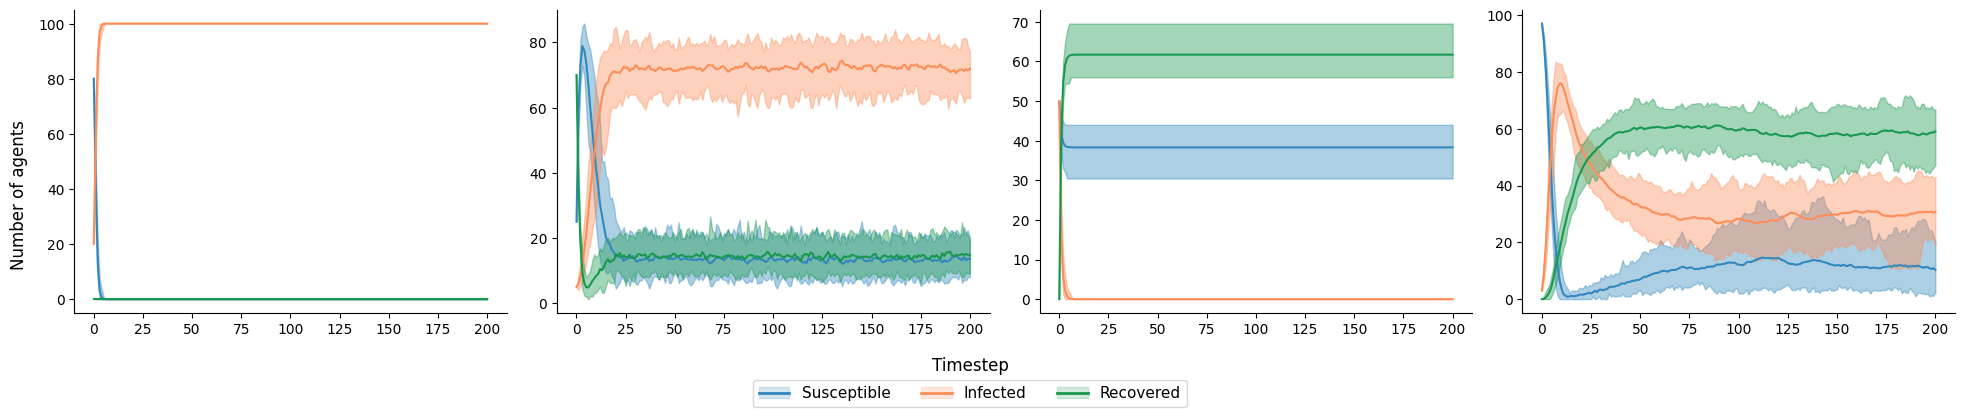

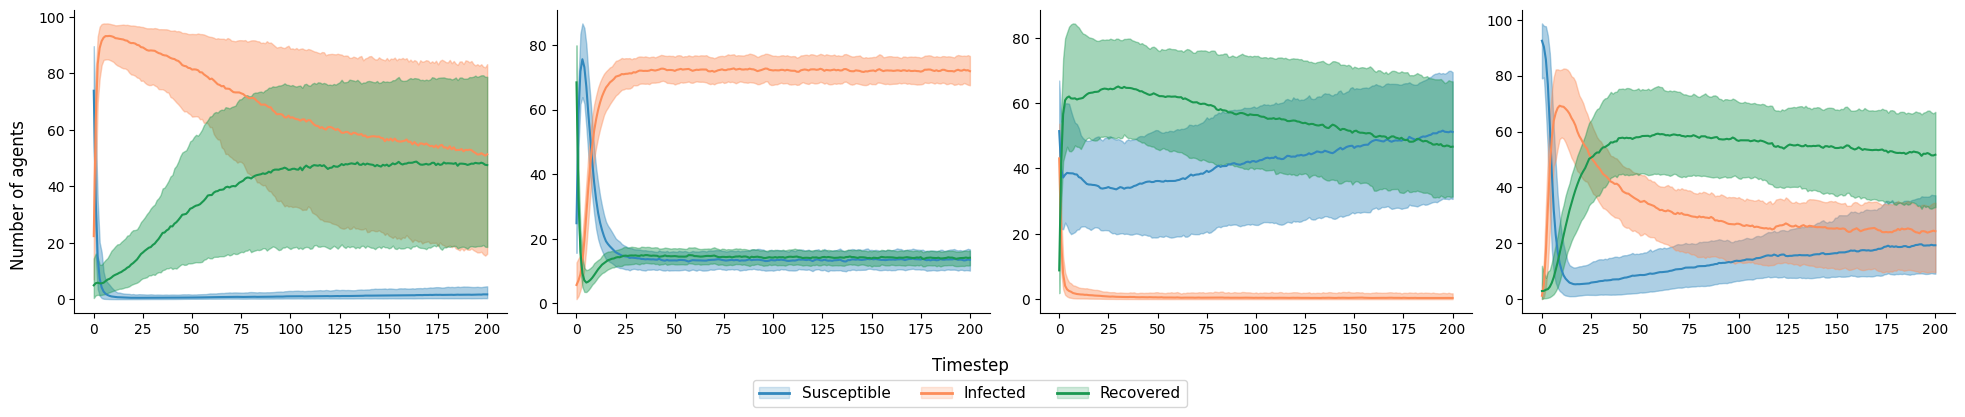

In [5]:
mcmlp = CheckPointer.load('trained_models/2025-06-06/09-36-01/')[0]
GRID_SIZE=10
NUM_STEPS=200
#P_MOVE=1.0
N_SIMS=50

SUSCEP_COLOUR='#3288bd'
INFECT_COLOUR='#fc8d59'
REC_COLOUR='#1a9850'

#SI
param_set1 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0, 
               'initial_infected':0.2, 'initial_recovered':0.0}
#SI less dense grid
param_set2 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0,  
              'initial_infected':0.2, 'initial_recovered':0.0}

#Lots of infected into recovery with waning
param_set3 = {'p_infect':0.01, 'p_recover':0.8, 'p_wane':0.05, 
               'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of infected into recovery without waning
param_set4 = {'p_infect':0.1, 'p_recover':0.8, 'p_wane':0.00, 
               'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of recovery into infected-ish
param_set5 = {'p_infect':0.3, 'p_recover':0.1, 'p_wane':0.5,  
              'initial_infected':0.05, 'initial_recovered':0.7}
#Very balanced between them
param_set6 = {'p_infect':0.3, 'p_recover':0.3, 'p_wane':0.2, 
               'initial_infected':0.3, 
              'initial_recovered':0.1}

#High prob inf, low initial, low rec and wane
param_set7 = {'p_infect':0.6, 'p_recover':0.05, 'p_wane':0.025, 
              'initial_infected':0.03, 'initial_recovered':0}



fig, axarr = plt.subplots(1,4,figsize=(20,4))
#param_set3,
param_sets = [param_set1, param_set5,param_set4,param_set7]


#[param_set1, param_set2, param_set3, param_set4, param_set5, param_set6, param_set7]
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
rng_key = jax.random.key(42)
for idx,param_set in enumerate(param_sets):
    # ABM GEN
    keys = jax.random.split(jax.random.fold_in(rng_key, idx),N_SIMS)
    multi_grid_series = abm(keys, GRID_SIZE, NUM_STEPS,param_set['p_infect'], 
                              param_set['p_recover'], param_set['p_wane'],0.0,
                              GRID_SIZE*GRID_SIZE,
                              #calc_start_n_initial(param_set['total_population'], GRID_SIZE),
                              calc_start_n_initial(param_set['initial_infected'],GRID_SIZE),
                              calc_start_n_initial(param_set['initial_recovered'], GRID_SIZE))
    
    statistics_over_time_jax = process_grid_time_series_jax(multi_grid_series)

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['mean'], color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['p2.5'], 
                        statistics_over_time_jax['Susceptible']['p97.5'], color=SUSCEP_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['mean'],color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['p2.5'], 
                        statistics_over_time_jax['Infected']['p97.5'], color=INFECT_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['mean'],color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['p2.5'], 
                        statistics_over_time_jax['Recovered']['p97.5'], color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')

legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/vanilla_sir_abm_g10s200_examples.pdf", bbox_inches='tight')
plt.show()

fig, axarr = plt.subplots(1,4,figsize=(20,4))
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
for idx, param_set in enumerate(param_sets):
    mcmlp_timeseries = partial(nnx.vmap(lambda module, x, key: module(x, key),
                                        in_axes=(None, None, 0),
                                        out_axes=0,
                                    ),mcmlp)(jnp.array([param_set['p_infect'], 
        param_set['p_recover'], param_set['p_wane'], param_set['initial_infected'],
        param_set['initial_recovered']
        ]),jax.random.split(jax.random.key(42),50))
    mcmlp_timeseries = mcmlp_timeseries*(GRID_SIZE*GRID_SIZE)
    mcmlp_infected,  mcmlp_recovered, mcmlp_susceptible = jnp.split(mcmlp_timeseries,3,axis=-1)


    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_susceptible,axis=0),color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_susceptible,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_susceptible,q=97.5,axis=0), color=SUSCEP_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_infected,axis=0), color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_infected,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_infected,q=97.5,axis=0), color=INFECT_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_recovered,axis=0), color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_recovered,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_recovered,q=97.5,axis=0), color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')
legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/vanilla_sir_mcmlp_g10s200_examples.pdf", bbox_inches='tight')

# SIR w/ Sparsity

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


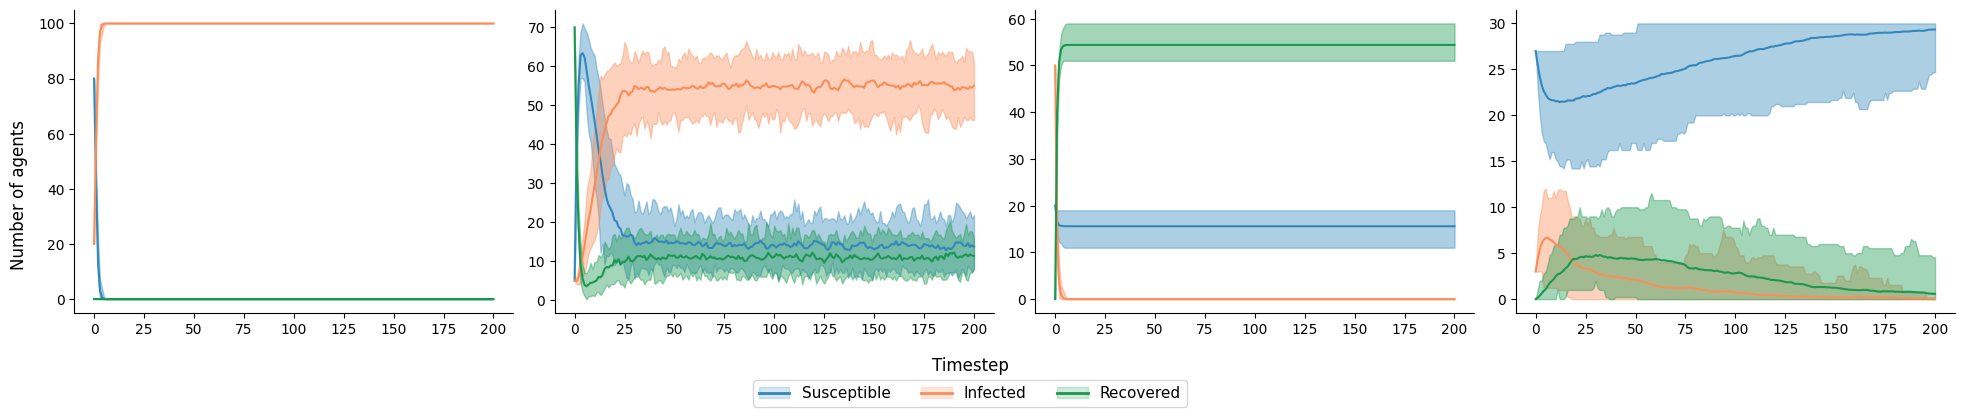

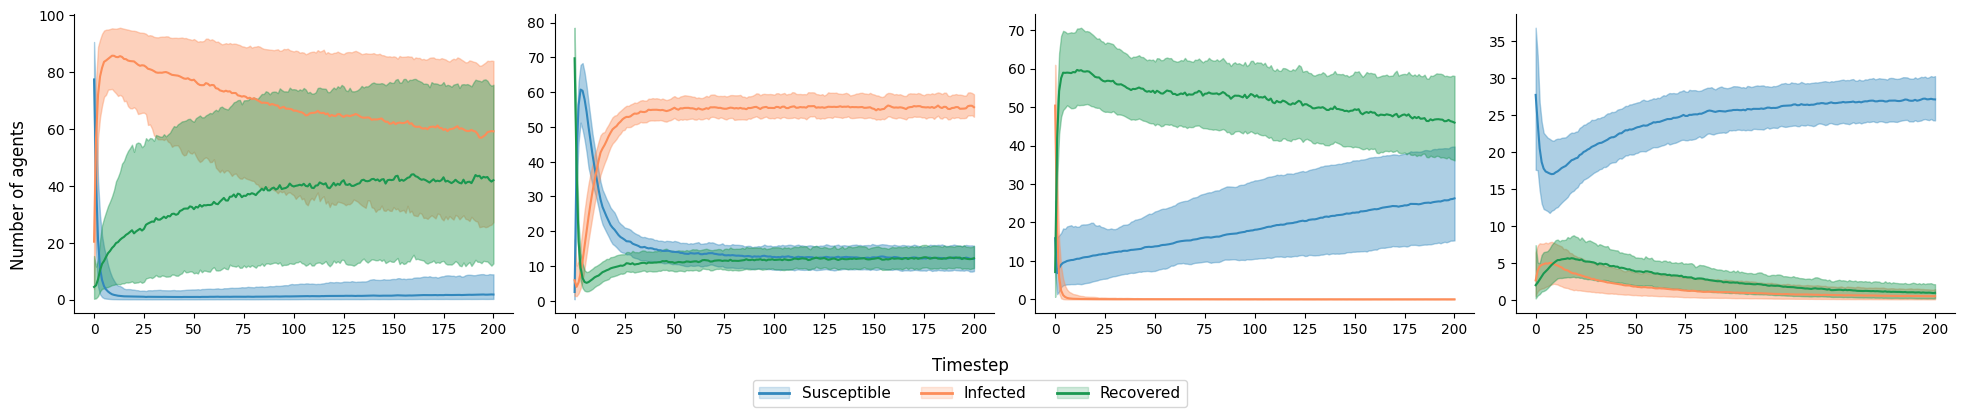

In [6]:
mcmlp = CheckPointer.load('trained_models/2025-06-06/10-05-25/')[0]
GRID_SIZE=10
NUM_STEPS=200
#P_MOVE=1.0
N_SIMS=50

SUSCEP_COLOUR='#3288bd'
INFECT_COLOUR='#fc8d59'
REC_COLOUR='#1a9850'

#SI
param_set1 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0, 
              'total_population':1.0, 'initial_infected':0.2, 'initial_recovered':0.0}
#SI less dense grid
param_set2 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0, 'total_population':0.5, 
              'initial_infected':0.2, 'initial_recovered':0.0}

#Lots of infected into recovery with waning
param_set3 = {'p_infect':0.01, 'p_recover':0.8, 'p_wane':0.05, 
              'total_population':0.7, 'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of infected into recovery without waning
param_set4 = {'p_infect':0.1, 'p_recover':0.8, 'p_wane':0.00, 
              'total_population':0.7, 'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of recovery into infected-ish
param_set5 = {'p_infect':0.3, 'p_recover':0.1, 'p_wane':0.5, 'total_population':0.8, 
              'initial_infected':0.05, 'initial_recovered':0.7}
#Very balanced between them
param_set6 = {'p_infect':0.3, 'p_recover':0.3, 'p_wane':0.2, 
              'total_population':0.7, 'initial_infected':0.3, 
              'initial_recovered':0.1}

#High prob inf, low initial, low rec and wane
param_set7 = {'p_infect':0.6, 'p_recover':0.05, 'p_wane':0.025, 'total_population':0.3,
              'initial_infected':0.03, 'initial_recovered':0}



fig, axarr = plt.subplots(1,4,figsize=(20,4))
#param_set3,
param_sets = [param_set1, param_set5,param_set4,param_set7]


#[param_set1, param_set2, param_set3, param_set4, param_set5, param_set6, param_set7]
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
rng_key = jax.random.key(42)
for idx,param_set in enumerate(param_sets):
    # ABM GEN
    keys = jax.random.split(jax.random.fold_in(rng_key, idx),N_SIMS)
    multi_grid_series = abm(keys, GRID_SIZE, NUM_STEPS,param_set['p_infect'], 
                              param_set['p_recover'], param_set['p_wane'],0.0,
                              calc_start_n_initial(param_set['total_population'], GRID_SIZE),
                              calc_start_n_initial(param_set['initial_infected'],GRID_SIZE),
                              calc_start_n_initial(param_set['initial_recovered'], GRID_SIZE))
    
    statistics_over_time_jax = process_grid_time_series_jax(multi_grid_series)

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['mean'], color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['p2.5'], 
                        statistics_over_time_jax['Susceptible']['p97.5'], color=SUSCEP_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['mean'],color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['p2.5'], 
                        statistics_over_time_jax['Infected']['p97.5'], color=INFECT_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['mean'],color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['p2.5'], 
                        statistics_over_time_jax['Recovered']['p97.5'], color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')

legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/no_move_sir_abm_g10s200_examples.pdf", bbox_inches='tight')
plt.show()

fig, axarr = plt.subplots(1,4,figsize=(20,4))
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
for idx, param_set in enumerate(param_sets):
    mcmlp_timeseries = partial(nnx.vmap(lambda module, x, key: module(x, key),
                                        in_axes=(None, None, 0),
                                        out_axes=0,
                                    ),mcmlp)(jnp.array([param_set['p_infect'], 
        param_set['p_recover'], param_set['p_wane'], 
        param_set['total_population'], param_set['initial_infected'],
        param_set['initial_recovered']
        ]),jax.random.split(jax.random.key(42),50))
    mcmlp_timeseries = mcmlp_timeseries*(GRID_SIZE*GRID_SIZE)
    mcmlp_infected,  mcmlp_recovered, mcmlp_susceptible = jnp.split(mcmlp_timeseries,3,axis=-1)


    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_susceptible,axis=0),color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_susceptible,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_susceptible,q=97.5,axis=0), color=SUSCEP_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_infected,axis=0), color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_infected,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_infected,q=97.5,axis=0), color=INFECT_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_recovered,axis=0), color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_recovered,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_recovered,q=97.5,axis=0), color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')
legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/no_move_sir_mcmlp_g10s200_examples.pdf", bbox_inches='tight')

## Full SIR MCMLP

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


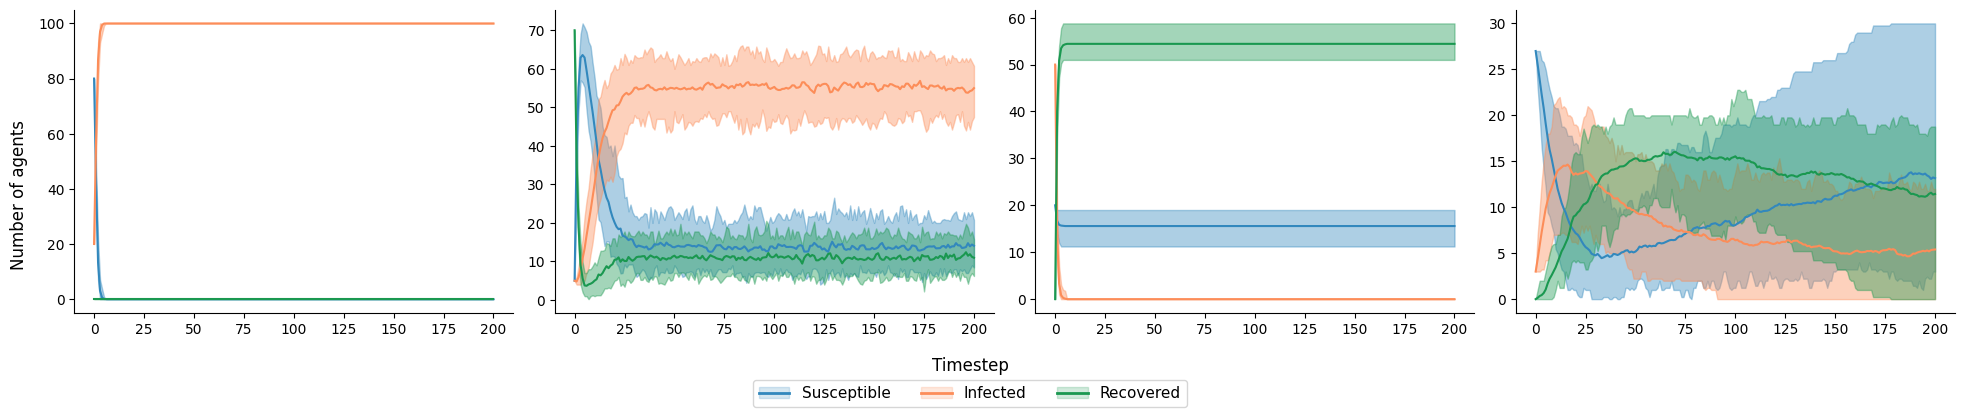

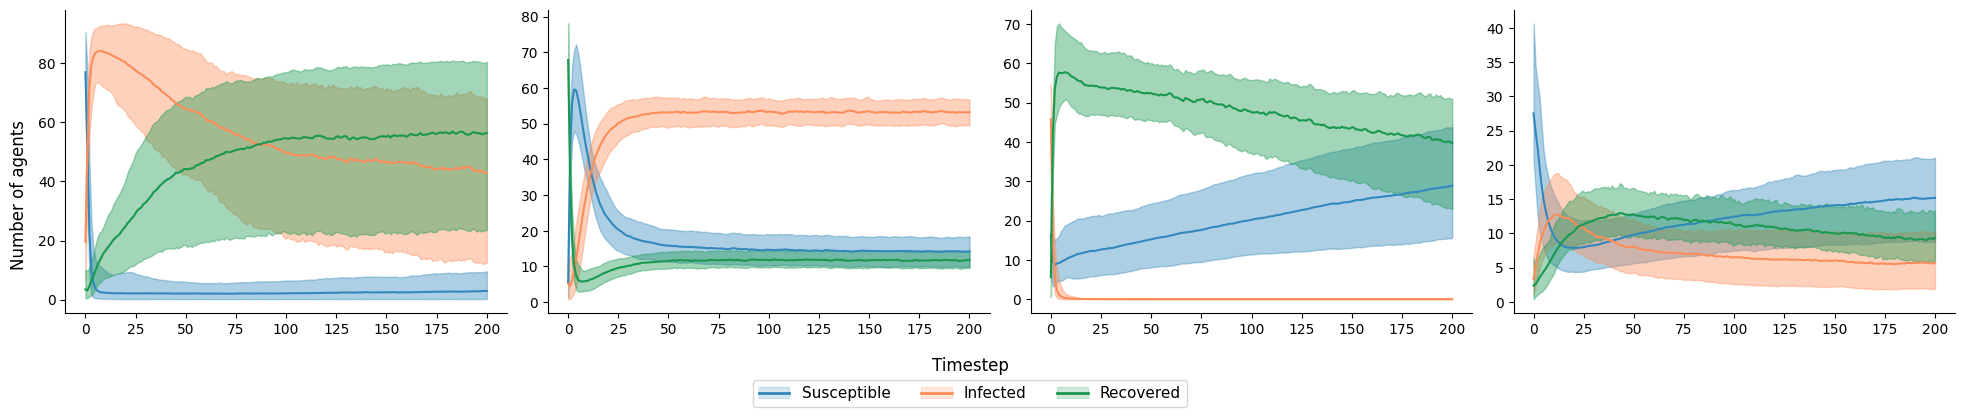

In [7]:
mcmlp = CheckPointer.load('trained_models/2025-06-07/09-23-33/')[0]
GRID_SIZE=10
NUM_STEPS=200
#P_MOVE=1.0
N_SIMS=50

SUSCEP_COLOUR='#3288bd'
INFECT_COLOUR='#fc8d59'
REC_COLOUR='#1a9850'

#SI
param_set1 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0, 'p_move':0.0,
              'total_population':1.0, 'initial_infected':0.2, 'initial_recovered':0.0}


#Lots of infected into recovery without waning
param_set4 = {'p_infect':0.1, 'p_recover':0.8, 'p_wane':0.00, 'p_move':1.0,
              'total_population':0.7, 'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of recovery into infected-ish
param_set5 = {'p_infect':0.3, 'p_recover':0.1, 'p_wane':0.5,'p_move':0.2, 'total_population':0.8, 
              'initial_infected':0.05, 'initial_recovered':0.7}


#High prob inf, low initial, low rec and wane
param_set7 = {'p_infect':0.6, 'p_recover':0.05, 'p_wane':0.025, 'p_move':0.5,'total_population':0.3,
              'initial_infected':0.03, 'initial_recovered':0}



fig, axarr = plt.subplots(1,4,figsize=(20,4))
#param_set3,
param_sets = [param_set1, param_set5,param_set4,param_set7]


#[param_set1, param_set2, param_set3, param_set4, param_set5, param_set6, param_set7]
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
rng_key = jax.random.key(42)
for idx,param_set in enumerate(param_sets):
    # ABM GEN
    keys = jax.random.split(jax.random.fold_in(rng_key, idx),N_SIMS)
    multi_grid_series = abm(keys, GRID_SIZE, NUM_STEPS,param_set['p_infect'], 
                              param_set['p_recover'], param_set['p_wane'],param_set['p_move'],
                              calc_start_n_initial(param_set['total_population'], GRID_SIZE),
                              calc_start_n_initial(param_set['initial_infected'],GRID_SIZE),
                              calc_start_n_initial(param_set['initial_recovered'], GRID_SIZE))
    
    statistics_over_time_jax = process_grid_time_series_jax(multi_grid_series)

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['mean'], color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['p2.5'], 
                        statistics_over_time_jax['Susceptible']['p97.5'], color=SUSCEP_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['mean'],color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['p2.5'], 
                        statistics_over_time_jax['Infected']['p97.5'], color=INFECT_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['mean'],color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['p2.5'], 
                        statistics_over_time_jax['Recovered']['p97.5'], color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')

legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/sir_abm_g10s200_examples.pdf", bbox_inches='tight')
plt.show()

fig, axarr = plt.subplots(1,4,figsize=(20,4))
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
for idx, param_set in enumerate(param_sets):
    mcmlp_timeseries = partial(nnx.vmap(lambda module, x, key: module(x, key),
                                        in_axes=(None, None, 0),
                                        out_axes=0,
                                    ),mcmlp)(jnp.array([param_set['p_infect'], 
        param_set['p_recover'], param_set['p_wane'], param_set['p_move'],
        param_set['total_population'], param_set['initial_infected'],
        param_set['initial_recovered']
        ]),jax.random.split(jax.random.key(42),50))
    mcmlp_timeseries = mcmlp_timeseries*(GRID_SIZE*GRID_SIZE)
    mcmlp_infected,  mcmlp_recovered, mcmlp_susceptible = jnp.split(mcmlp_timeseries,3,axis=-1)


    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_susceptible,axis=0),color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_susceptible,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_susceptible,q=97.5,axis=0), color=SUSCEP_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_infected,axis=0), color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_infected,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_infected,q=97.5,axis=0), color=INFECT_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_recovered,axis=0), color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_recovered,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_recovered,q=97.5,axis=0), color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')
legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/sir_mcmlp_g10s200_examples.pdf", bbox_inches='tight')

# G10 S30

/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


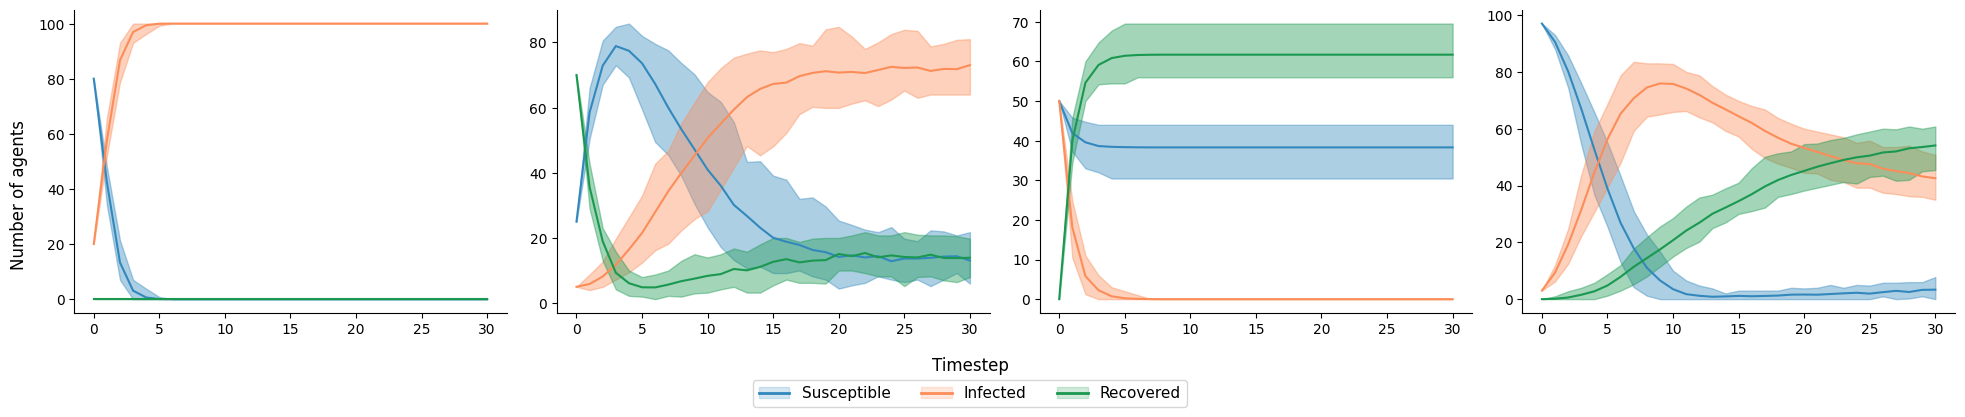

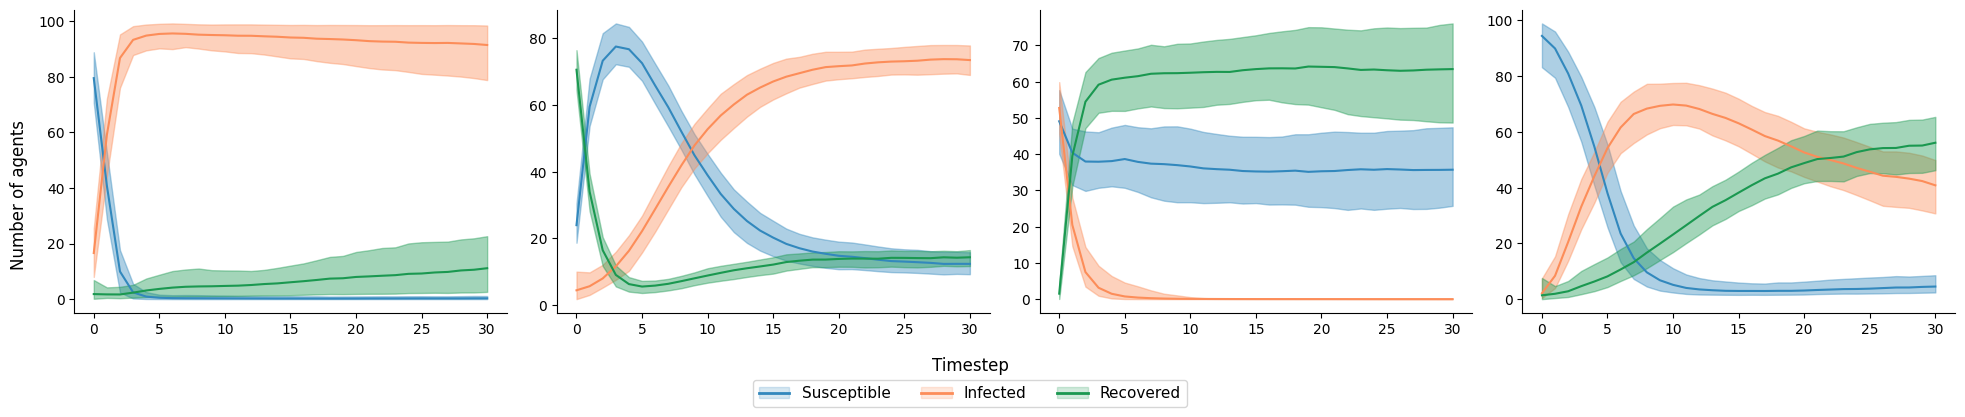

In [5]:
mcmlp = CheckPointer.load('trained_models/2025-06-10/19-23-24')[0]
GRID_SIZE=10
NUM_STEPS=30#200
#P_MOVE=1.0
N_SIMS=50

SUSCEP_COLOUR='#3288bd'
INFECT_COLOUR='#fc8d59'
REC_COLOUR='#1a9850'

#SI
param_set1 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0, 
               'initial_infected':0.2, 'initial_recovered':0.0}
#SI less dense grid
param_set2 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0,  
              'initial_infected':0.2, 'initial_recovered':0.0}

#Lots of infected into recovery with waning
param_set3 = {'p_infect':0.01, 'p_recover':0.8, 'p_wane':0.05, 
               'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of infected into recovery without waning
param_set4 = {'p_infect':0.1, 'p_recover':0.8, 'p_wane':0.00, 
               'initial_infected':0.5, 'initial_recovered':0.0}

#Lots of recovery into infected-ish
param_set5 = {'p_infect':0.3, 'p_recover':0.1, 'p_wane':0.5,  
              'initial_infected':0.05, 'initial_recovered':0.7}
#Very balanced between them
param_set6 = {'p_infect':0.3, 'p_recover':0.3, 'p_wane':0.2, 
               'initial_infected':0.3, 
              'initial_recovered':0.1}

#High prob inf, low initial, low rec and wane
param_set7 = {'p_infect':0.6, 'p_recover':0.05, 'p_wane':0.025, 
              'initial_infected':0.03, 'initial_recovered':0}



fig, axarr = plt.subplots(1,4,figsize=(20,4))
#param_set3,
param_sets = [param_set1, param_set5,param_set4,param_set7]


#[param_set1, param_set2, param_set3, param_set4, param_set5, param_set6, param_set7]
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
rng_key = jax.random.key(42)
for idx,param_set in enumerate(param_sets):
    # ABM GEN
    keys = jax.random.split(jax.random.fold_in(rng_key, idx),N_SIMS)
    multi_grid_series = abm(keys, GRID_SIZE, NUM_STEPS,param_set['p_infect'], 
                              param_set['p_recover'], param_set['p_wane'],0.0,
                              GRID_SIZE*GRID_SIZE,
                              #calc_start_n_initial(param_set['total_population'], GRID_SIZE),
                              calc_start_n_initial(param_set['initial_infected'],GRID_SIZE),
                              calc_start_n_initial(param_set['initial_recovered'], GRID_SIZE))
    
    statistics_over_time_jax = process_grid_time_series_jax(multi_grid_series)

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['mean'], color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Susceptible']['p2.5'], 
                        statistics_over_time_jax['Susceptible']['p97.5'], color=SUSCEP_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['mean'],color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Infected']['p2.5'], 
                        statistics_over_time_jax['Infected']['p97.5'], color=INFECT_COLOUR,alpha=0.4 )

    axarr[idx].plot(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['mean'],color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),statistics_over_time_jax['Recovered']['p2.5'], 
                        statistics_over_time_jax['Recovered']['p97.5'], color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')

legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/vanilla_sir_abm_g10s30_examples.pdf", bbox_inches='tight')
plt.show()

fig, axarr = plt.subplots(1,4,figsize=(20,4))
#fig.subplots_adjust(hspace=0.5, top=0.96, bottom=0.04)
for idx, param_set in enumerate(param_sets):
    mcmlp_timeseries = partial(nnx.vmap(lambda module, x, key: module(x, key),
                                        in_axes=(None, None, 0),
                                        out_axes=0,
                                    ),mcmlp)(jnp.array([param_set['p_infect'], 
        param_set['p_recover'], param_set['p_wane'], param_set['initial_infected'],
        param_set['initial_recovered']
        ]),jax.random.split(jax.random.key(42),50))
    mcmlp_timeseries = mcmlp_timeseries*(GRID_SIZE*GRID_SIZE)
    mcmlp_infected,  mcmlp_recovered, mcmlp_susceptible = jnp.split(mcmlp_timeseries,3,axis=-1)


    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_susceptible,axis=0),color=SUSCEP_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_susceptible,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_susceptible,q=97.5,axis=0), color=SUSCEP_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_infected,axis=0), color=INFECT_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_infected,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_infected,q=97.5,axis=0), color=INFECT_COLOUR,alpha=0.4 )
    
    axarr[idx].plot(jnp.arange(NUM_STEPS+1),jnp.mean(mcmlp_recovered,axis=0), color=REC_COLOUR)
    axarr[idx].fill_between(jnp.arange(NUM_STEPS+1),jnp.percentile(mcmlp_recovered,q=2.5,axis=0), 
                        jnp.percentile(mcmlp_recovered,q=97.5,axis=0), color=REC_COLOUR,alpha=0.4 )
    axarr[idx].spines[["right", "top"]].set_visible(False)
    # axarr[idx].set_ylabel('Count')
    # axarr[idx].set_xlabel('Timestep')
legend_handles=[]
legend_labels=['Susceptible', 'Infected','Recovered']
for colour in [SUSCEP_COLOUR, INFECT_COLOUR, REC_COLOUR]:
    legend_handles.append((Line2D([0],[0],color=colour,
                        linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.2)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=len(legend_labels),fontsize=11)

fig.supxlabel('Timestep',y=0.05,fontsize=12)
fig.supylabel('Number of agents',fontsize=12)#,x=-0.0005)
plt.tight_layout(rect=[0.01, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig("../06_04_viz/huge_vanilla_sir_mcmlp_g10s30_examples.pdf", bbox_inches='tight')